In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.linear_model import SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import yfinance as yf
import os
from xgboost import XGBRegressor

In [3]:
# Load Dataset
file_path = "Coca-Cola_stock_history.csv"
data = pd.read_csv(file_path)

In [4]:
data.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,1962-01-02,0.050016,0.051378,0.050016,0.050016,806400,0.0,0
1,1962-01-03,0.049273,0.049273,0.048159,0.048902,1574400,0.0,0
2,1962-01-04,0.049026,0.049645,0.049026,0.049273,844800,0.0,0
3,1962-01-05,0.049273,0.049892,0.048035,0.048159,1420800,0.0,0
4,1962-01-08,0.047787,0.047787,0.046735,0.047664,2035200,0.0,0


In [5]:
data.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends',
       'Stock Splits'],
      dtype='object')

In [6]:
data.index

RangeIndex(start=0, stop=15311, step=1)

In [7]:
data.tail()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
15306,2022-10-20 00:00:00-04:00,55.770000,55.919998,54.959999,55.080002,16905100,0.0,0
15307,2022-10-21 00:00:00-04:00,55.000000,56.110001,54.990002,55.959999,15028000,0.0,0
15308,2022-10-24 00:00:00-04:00,56.639999,57.730000,56.570000,57.570000,17416700,0.0,0
15309,2022-10-25 00:00:00-04:00,59.040001,59.110001,57.750000,58.950001,28829900,0.0,0
15310,2022-10-26 00:00:00-04:00,59.009998,59.779999,58.860001,59.389999,15831400,0.0,0


In [8]:
data.shape

(15311, 8)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15311 entries, 0 to 15310
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          15311 non-null  object 
 1   Open          15311 non-null  float64
 2   High          15311 non-null  float64
 3   Low           15311 non-null  float64
 4   Close         15311 non-null  float64
 5   Volume        15311 non-null  int64  
 6   Dividends     15311 non-null  float64
 7   Stock Splits  15311 non-null  int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 957.1+ KB


In [10]:
data.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,15311.000000,15311.000000,15311.000000,15311.000000,1.531100e+04,15311.000000,15311.000000
mean,11.812883,11.906708,11.717375,11.815409,9.139213e+06,0.001678,0.001110
std,15.025726,15.133336,14.915580,15.026316,7.957947e+06,0.021302,0.049148
min,0.037154,0.037279,0.034890,0.037028,7.680000e+04,0.000000,0.000000
25%,0.238453,0.240305,0.236415,0.238312,2.889600e+06,0.000000,0.000000
50%,4.935146,4.980985,4.884242,4.937339,7.708800e+06,0.000000,0.000000
75%,17.383926,17.612844,17.168283,17.415106,1.307130e+07,0.000000,0.000000
max,66.037933,66.235058,64.776308,65.259270,1.241690e+08,0.440000,3.000000


In [11]:
data.isnull().sum()

Date            0
Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64

In [19]:
# Convert Date column to datetime and remove timezone info if present
#data['Date'] = pd.to_datetime(data['Date'], utc=True).dt.tz_localize(None)
data['Date'] = pd.to_datetime(data['Date'], format='ISO8601', utc=True, errors='coerce').dt.tz_localize(None)
data.sort_values('Date', inplace=True)
data['Date'].head()

0   1962-01-02
1   1962-01-03
2   1962-01-04
3   1962-01-05
4   1962-01-08
Name: Date, dtype: datetime64[ns]

In [21]:
# Feature Engineering
# Add Moving Averages
data['MA_20'] = data['Close'].rolling(window=20).mean()
data['MA_50'] = data['Close'].rolling(window=50).mean()

In [22]:
# Add Daily Returns
data['Daily_Return'] = data['Close'].pct_change()

In [23]:
# Add Volatility
data['Volatility'] = data['Daily_Return'].rolling(window=20).std()

In [24]:
# Drop NA values due to rolling calculations
data.dropna(inplace=True)

In [25]:
# Prepare Data for Machine Learning
features = [col for col in ['Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits', 'MA_20', 'MA_50', 'Daily_Return', 'Volatility'] if col in data.columns]
target = 'Close'
X = data[features]
y = data[target]

In [26]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [27]:
# Train Models
rfg_model = RandomForestRegressor(n_estimators=100, random_state=42)
rfg_model.fit(X_train, y_train)

svr_model = SVR(kernel='rbf')
svr_model.fit(X_train, y_train)

sgd_model = SGDRegressor()
sgd_model.fit(X_train, y_train)

dt_model = DecisionTreeRegressor()
dt_model.fit(X_train, y_train)

gbr_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gbr_model.fit(X_train, y_train)

knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train, y_train)

xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [28]:
# Make Predictions
y_pred_rfg = rfg_model.predict(X_test)
y_pred_svr = svr_model.predict(X_test)
y_pred_sgd = sgd_model.predict(X_test)
y_pred_dt = dt_model.predict(X_test)
y_pred_gbr = gbr_model.predict(X_test)
y_pred_knn = knn_model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)

In [44]:
# Evaluate Models
models = {
    'SVR': y_pred_svr,
    'RFG': y_pred_rfg,
    'SGD': y_pred_sgd,
    'Decision Tree': y_pred_dt,
    'Gradient Boosting': y_pred_gbr,
    'KNN': y_pred_knn,
    'XGBoost': y_pred_xgb
}
best_model = None
best_mse = float('inf')
best_mae = float('inf')
for model_name, y_pred in models.items():
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    if mse < best_mse:
        best_mse = mse
        best_mae = mae
        best_model = model_name
    print(f"{model_name} - Mean Squared Error: {mse}, Mean Absolute Error: {mae}")
    
#The best model for the given dataset among all the predicted models
print("\n")
print(f"The best model is {best_model} with MSE: {best_mse} and MAE: {best_mae}")

SVR - Mean Squared Error: 797.2010934413103, Mean Absolute Error: 25.986687920642737
RFG - Mean Squared Error: 327.97684445274587, Mean Absolute Error: 14.669374621065108
SGD - Mean Squared Error: 3.524648757577251e+46, Mean Absolute Error: 1.7214085911461623e+23
Decision Tree - Mean Squared Error: 324.69119714984015, Mean Absolute Error: 14.572430437343595
Gradient Boosting - Mean Squared Error: 328.9633149346752, Mean Absolute Error: 14.702669500222191
KNN - Mean Squared Error: 945.0979012782147, Mean Absolute Error: 28.587185453566395
XGBoost - Mean Squared Error: 357.64469704572514, Mean Absolute Error: 15.579452720063767


The best model is Decision Tree with MSE: 324.69119714984015 and MAE: 14.572430437343595


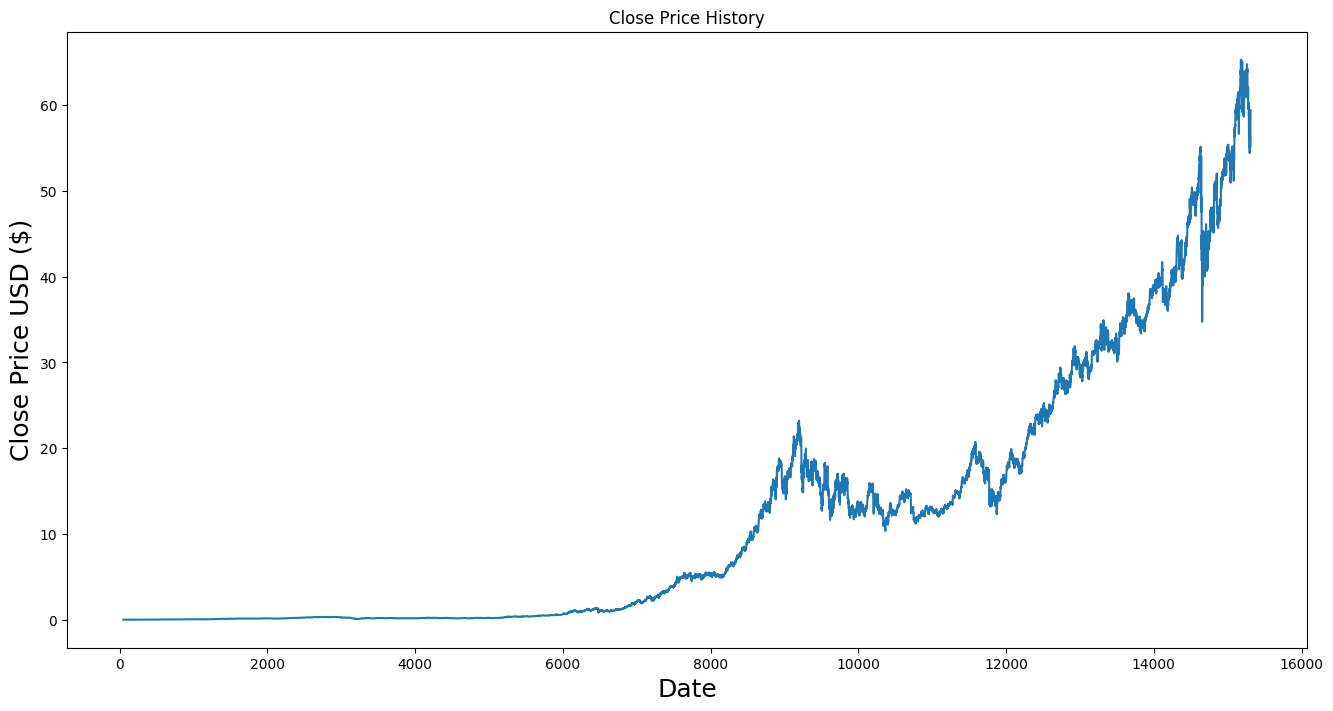

In [30]:
#Close Price Value vs Date
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(data['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

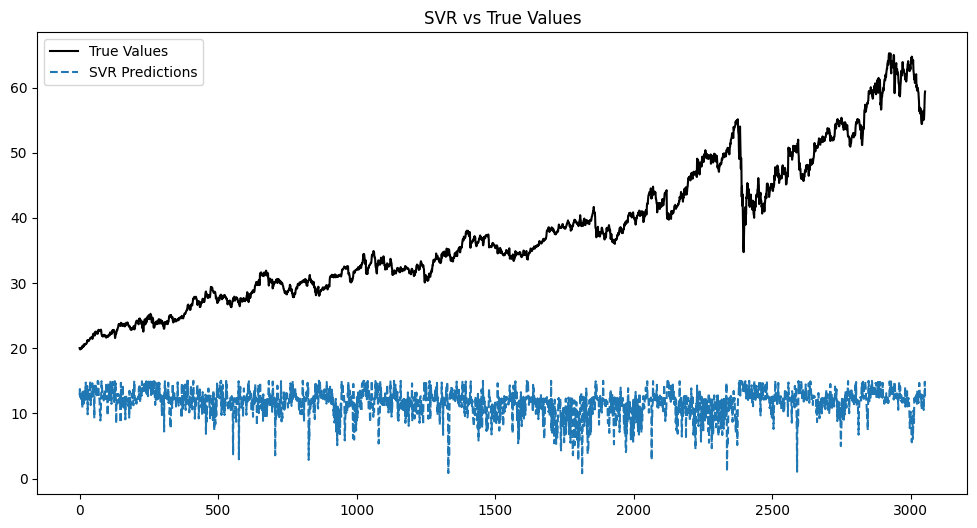

In [ ]:
# Plot Predictions vs True Values
plt.figure(figsize=(12,6))
plt.plot(y_test.values, label='True Values', color='black')
plt.plot(y_pred_svr, label='SVR Predictions', linestyle='dashed')
plt.title('SVR vs True Values')
plt.legend()
plt.show()

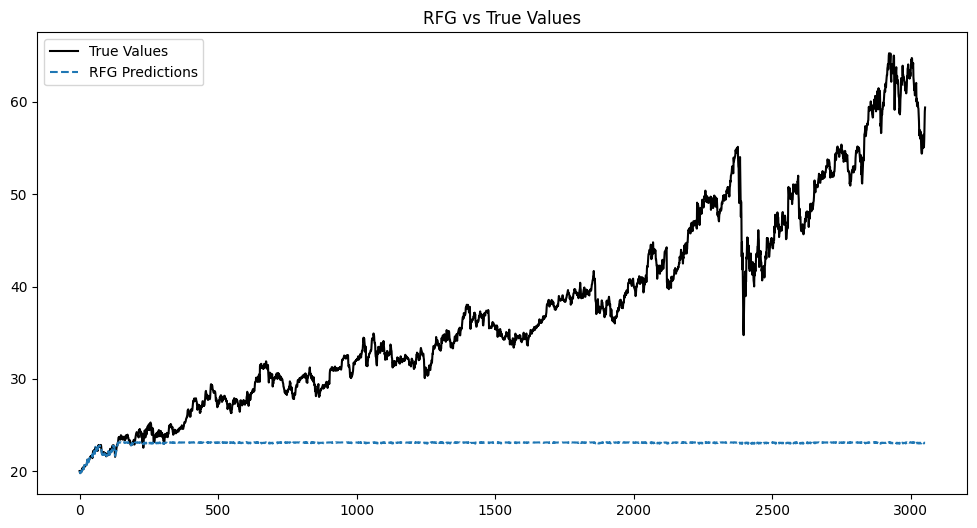

In [32]:
# Plot Predictions vs True Values
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='True Values', color='black')
plt.plot(y_pred_rfg, label='RFG Predictions', linestyle='dashed')
plt.title('RFG vs True Values')
plt.legend()
plt.show()

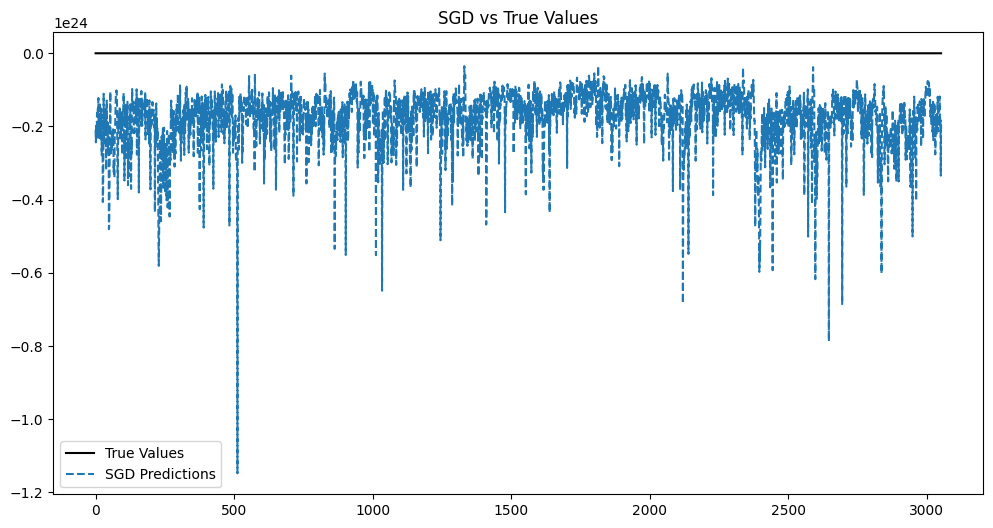

In [33]:
# Plot Predictions vs True Values
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='True Values', color='black')
plt.plot(y_pred_sgd, label='SGD Predictions', linestyle='dashed')
plt.title('SGD vs True Values')
plt.legend()
plt.show()

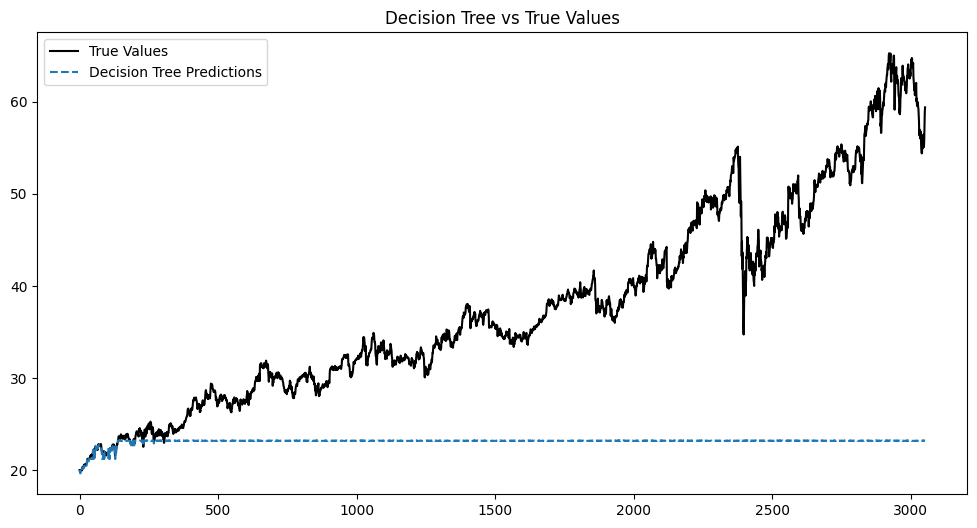

In [34]:
# Plot Predictions vs True Values
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='True Values', color='black')
plt.plot(y_pred_dt, label='Decision Tree Predictions', linestyle='dashed')
plt.title('Decision Tree vs True Values')
plt.legend()
plt.show()

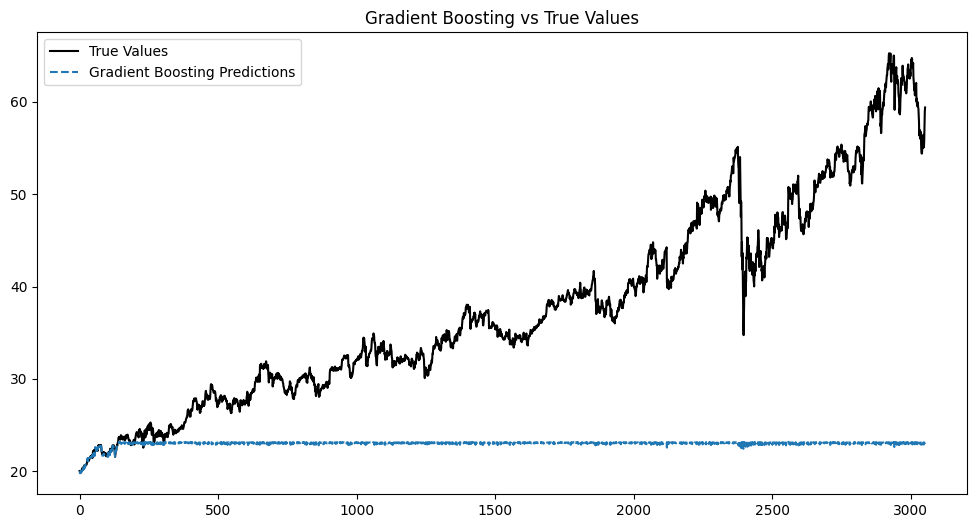

In [35]:
# Plot Predictions vs True Values
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='True Values', color='black')
plt.plot(y_pred_gbr, label='Gradient Boosting Predictions', linestyle='dashed')
plt.title('Gradient Boosting vs True Values')
plt.legend()
plt.show()

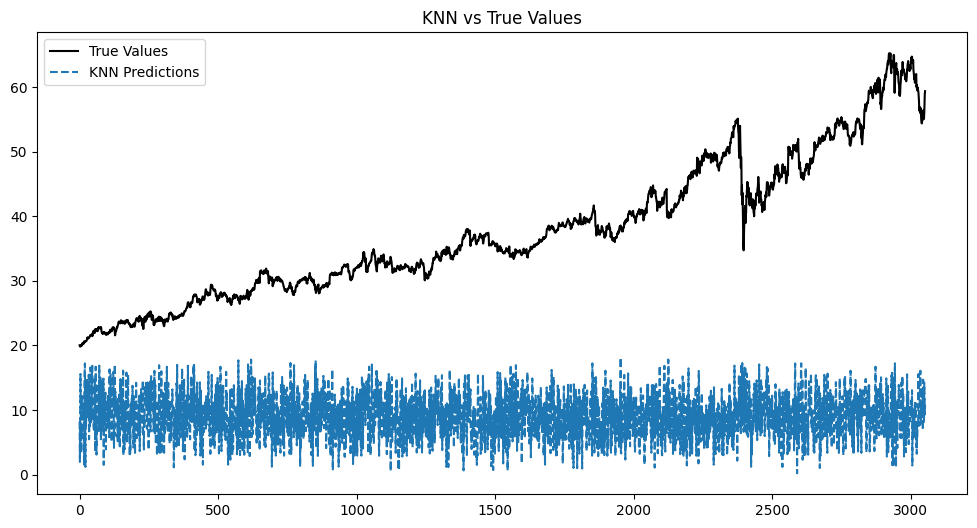

In [36]:
# Plot Predictions vs True Values
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='True Values', color='black')
plt.plot(y_pred_knn, label='KNN Predictions', linestyle='dashed')
plt.title('KNN vs True Values')
plt.legend()
plt.show()

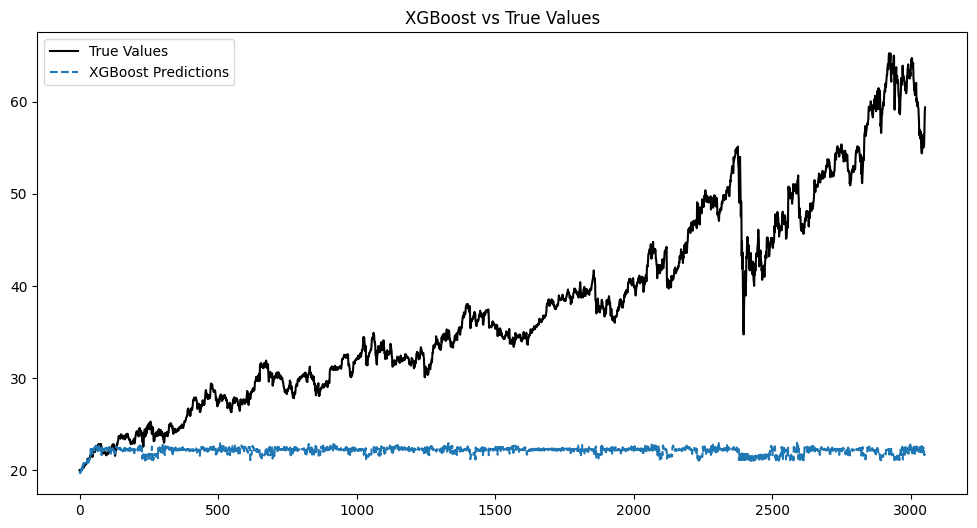

In [37]:
# Plot Predictions vs True Values
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='True Values', color='black')
plt.plot(y_pred_xgb, label='XGBoost Predictions', linestyle='dashed')
plt.title('XGBoost vs True Values')
plt.legend()
plt.show()